##### Basado en código de Tensorflow.org

In [71]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Generative Adversarial Network

### Setup

In [72]:
import tensorflow as tf

In [73]:
tf.__version__

'2.15.0'

In [74]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-6gyd0qo6
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-6gyd0qo6
  Resolved https://github.com/tensorflow/docs to commit 8b36191001b53bfce4fe15b77e243fbd7f382e41
  Preparing metadata (setup.py) ... done


In [75]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [76]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [77]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images) / 255  # Normalize the images to [0, 1]
#plot.imshow normaliza los valores de la imagen antes de mostrarla

In [78]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128 # 256

In [79]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

In [80]:
noise_dim = 64 #100

### The Generator


In [81]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(128, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add (layers.Dense (128*2))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add (layers.Dense (128*4))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add (layers.Dense (128*8))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add (layers.Dense (28*28,activation='sigmoid' ))
    model.add (layers.Reshape ((28,28,1)))


    return model



Use the (as yet untrained) generator to create an image.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               8320      
                                                                 
 batch_normalization_8 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 256)               33024     
                                                                 
 batch_normalization_9 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 256)              

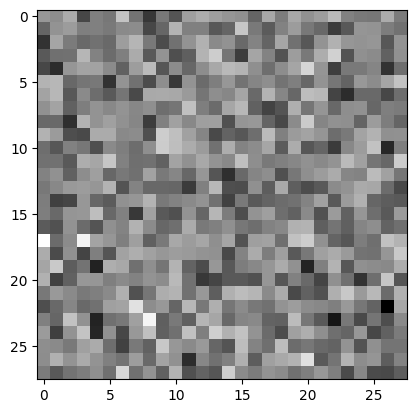

In [82]:
generator = make_generator_model()

print (generator.summary())

noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
#normaliza los valores de la imagen antes de mostrarla

### The Discriminator


In [83]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Flatten(input_shape=[28, 28, 1]))
    model.add (layers.Dense (128*4))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add (layers.Dense (128*2))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add (layers.Dense (128*1))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [84]:
discriminator = make_discriminator_model()
print (discriminator.summary())
decision = discriminator(generated_image)
print (decision)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_23 (Dense)            (None, 512)               401920    
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 512)               0         
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_24 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 256)               0         
                                                                 
 dropout_7 (Dropout)         (None, 256)              

## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [85]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [86]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [87]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [88]:
#generator_optimizer = tf.keras.optimizers.Adam(1e-4)
#discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [89]:
checkpoint_dir = './DCGAN_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [90]:
#EPOCHS = 50 # 50
#noise_dim = 64 #100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [91]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        real_output = discriminator(images, training=True)

        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    with tf.GradientTape() as gen_tape, tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))


In [92]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            #print ("len image_batch:", len(image_batch))
            train_step(image_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

**Generate and save images**


In [93]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.imshow(predictions[i, :, :, 0] * 255, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.jpeg'.format(epoch),format='jpeg', )
    plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

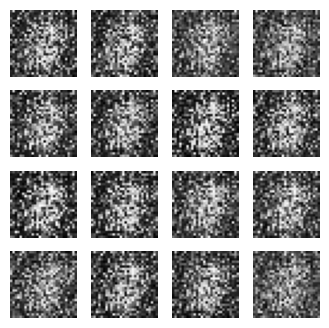

In [ ]:
#
EPOCHS = 1 # 50
train(train_dataset, EPOCHS)

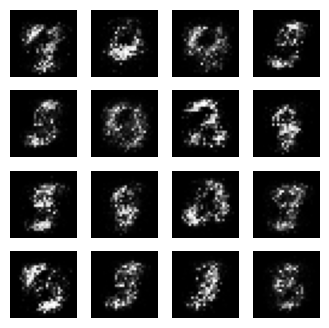

In [ ]:
#
EPOCHS = 10 # 50
train(train_dataset, EPOCHS)

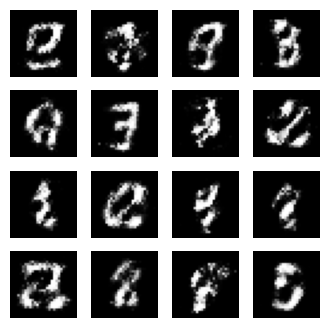

In [ ]:
#
EPOCHS = 30 # 50
train(train_dataset, EPOCHS)

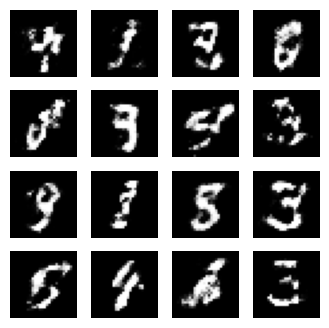

In [ ]:
#
EPOCHS = 50 # 50
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.jpeg'.format(epoch_no))

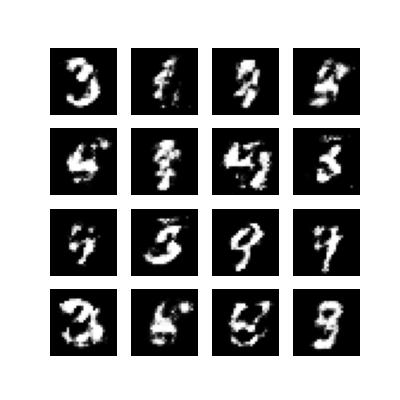

In [ ]:
display_image(EPOCHS)

# WGAN-GP


## Model Creation

In [95]:
noise_dim = 64 #100

In [96]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(128, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add (layers.Dense (128*2))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add (layers.Dense (128*4))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add (layers.Dense (128*8))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add (layers.Dense (28*28,activation='sigmoid' ))
    model.add (layers.Reshape ((28,28,1)))


    return model



In [97]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Flatten(input_shape=[28, 28, 1]))
    model.add (layers.Dense (128*4))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add (layers.Dense (128*2))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add (layers.Dense (128*1))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


## Losses and Optimizers

### Wasserstein Generator Loss

In [98]:
def wasserstein_generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

### Wasserstein Discriminator Loss

In [99]:
def wasserstein_discriminator_loss(real_output, fake_output):
    return tf.reduce_mean(real_output) - tf.reduce_mean(fake_output)

### Save checkpoints

In [100]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training loop

In [101]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def w_train_step_gc(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        real_output = discriminator(images, training=True)

        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    with tf.GradientTape() as gen_tape, tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))


## Train the model

### Gradient Penalty

In [102]:
def gradient_penalty(batch_size, real_images, fake_images):
    alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
    diff = fake_images - real_images
    interpolated = real_images + alpha * diff

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred = discriminator(interpolated, training=True)

        # !!!!!!!!!!!!! esto en las diapos esta fuera
        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)

    return gp

In [108]:
@tf.function
def w_train_step_gc(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        real_output = discriminator(images, training=True)

        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = wasserstein_generator_loss(fake_output)
        disc_loss = wasserstein_discriminator_loss(real_output, fake_output)

        # calculate gradient penalty
        gp = gradient_penalty(BATCH_SIZE, images, generated_images)

        # dicriminator loss with gradient penalty
        disc_loss += gp * 60.0  # gradient penalty weight

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [109]:
def w_train_gc(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # generate images for visualization
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # save model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print(f'[+] Epoch {epoch+1} time {time.time()-start} sec')

    # generate images after last epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

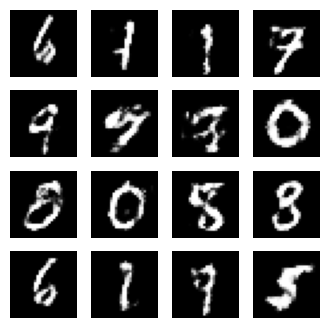

In [110]:
#
EPOCHS = 150 # 50
w_train_gc(train_dataset, EPOCHS)